## This notebook describes the reconstruction process, once with the MC truth directions of photons (which includes shower spread and scattering) and then with all information limiting processes.

In [1]:
import sys
import os
os.environ["CUDA VISIBLE DEVICES"]="4"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
np.set_printoptions(threshold=sys.maxsize)
from scipy import stats
from sklearn.model_selection import train_test_split
import math
import plotly.graph_objs as go
from scipy.optimize import minimize
from scipy.stats import norm

In [2]:
plt.rcParams['figure.figsize'] = [8., 8.]
plt.rcParams['xtick.labelsize'] = 17
plt.rcParams['ytick.labelsize'] = 17 
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['legend.fontsize'] = 14

## Functions 

In [3]:
#Likelihood calculation using only direction information for a hypothesis theta,phi

def likelihood_function_cherenkov(x, hits, bin_centers, kde_curve):
    theta, phi = x
    dir_reco = np.array([np.sin(theta) * np.cos(phi), np.sin(theta) * np.sin(phi), np.cos(theta)])
    dir_reco = dir_reco 
    angles =  np.arccos(np.dot(hits,dir_reco))

    # Calculate the KDE values using the kde_curve as a function
    kde_values = np.interp(angles, bin_centers, kde_curve)

    # Combine the PDFs
    cherenkov_pdf = kde_values

    # Compute the log-likelihood
    log_likelihood = np.sum(np.log(cherenkov_pdf))
    nllh = -log_likelihood

    return nllh

In [4]:
#Likelihood calculation using only timing information for a hypothesis theta,phi

def likelihood_function_santa(x, t_obs, r, q, bin_centers, kde_curve):
    theta, phi = x
    
    n_ph = 1.319
    c = 0.3
    n_gr = 1.356
    
    r = np.array(r)
    q = np.array(q)
    
    u = np.array([np.sin(theta) * np.cos(phi), np.sin(theta) * np.sin(phi), np.cos(theta)])
    
    cross_prod = np.cross(u, r - q)
    d_gamma = n_ph * np.sqrt((1 / (n_ph ** 2 - 1)) * np.sum(cross_prod ** 2, axis=1))
    t_geo = (1/c) * (np.abs(np.dot(r - q, u)) + (d_gamma/n_ph)*(n_ph*n_gr-1))
        
    t_geo = np.array(t_geo)
    t_obs = np.array(t_obs)
    delta_t = np.abs(t_geo - t_obs)
    
    # Calculate the KDE values using the kde_curve as a function
    kde_values = np.interp(delta_t, bin_centers, kde_curve)

    # Combine the PDFs
    pdfs = kde_values
    
    # Compute the log-likelihood
    log_likelihood = np.sum(np.log(pdfs))
    nllh = -log_likelihood
    
    return nllh

In [46]:
#Likelihood calculation using direction & timing information for a hypothesis theta,phi

def likelihood_function_combined(x, t_obs, r, q, hits, bin_centers_angles, bin_centers_delta_t, kde_curve):
    dir_x,dir_y,dir_z = x
    norm_dir = np.sqrt(dir_x**2 + dir_y**2 + dir_z**2)
    dir_x /= norm_dir
    dir_y /= norm_dir
    dir_z /= norm_dir
    
    delta_t=[]
    n_ph = 1.319
    c = 0.3
    n_gr = 1.356

    dir_reco = np.array([dir_x, dir_y, dir_z])
    
    angles = np.arccos(np.dot(hits, dir_reco))
    
    r = np.array(r)
    q = np.array(q)
    
    cross_prod = np.cross(dir_reco, r - q)
    d_gamma = n_ph * np.sqrt((1 / (n_ph ** 2 - 1)) * np.sum(cross_prod ** 2, axis=1))
    t_geo = (1/c) * (np.abs(np.dot(r - q, dir_reco)) + (d_gamma/n_ph) * (n_ph * n_gr - 1))
        
    t_geo = np.array(t_geo)
    t_obs = np.array(t_obs)
    delta_t = np.abs(t_geo - t_obs)
#delta_t = np.log(np.abs(t_obs-t_geo))
    
    # Perform interpolation to compute the KDE values
    interp_func = interp2d(bin_centers_angles, bin_centers_delta_t, kde_curve.T)
    kde_values = interp_func(angles, delta_t)
    
    log_likelihood = np.sum(np.log(kde_values))
    nllh = -log_likelihood

    return nllh

In [6]:
#Calculates the angle between hit photon and the nearest PMT axis direction. Then includes the acceptance curve information of an mDOM PMT by rejection sampling. If photon is accepted, it is assumed that photon arrives from along the PMT direction. This is a valid assumption since in reality the hit PMT is known.

def get_pmt_axis_spatial_prox_acceptance(d_theta, d_phi, imp_x, imp_y, imp_z):
    # Define the number of PMTs in each row
    num_pmts_per_row = [5, 7, 7, 5]
    num_pmts = sum(num_pmts_per_row)
    # Define the latitudinal bands and their respective latitudes
    lat_bands = [np.pi/8, 3*np.pi/8, 5*np.pi/8, 7*np.pi/8]
    # Calculate the point of photon impact based on d_theta and d_phi
    x = np.sin(d_theta) * np.cos(d_phi)
    y = np.sin(d_theta) * np.sin(d_phi)
    z = np.cos(d_theta)
    point_of_impact = np.array([x, y, z])
    # Generate evenly spaced points along each band
    points = []
    for i in range(len(lat_bands)):
        num_pmts_in_band = num_pmts_per_row[i]
        lat = lat_bands[i]
        for j in range(num_pmts_in_band):
            lon = j * (2*np.pi/num_pmts_in_band)
            px = np.sin(lat) * np.cos(lon)
            py = np.sin(lat) * np.sin(lon)
            pz = np.cos(lat)
            points.append([px, py, pz])
    points = np.array(points)
    # Calculate the Euclidean distance between point_of_impact and all of the PMT axis vectors
    distances = np.linalg.norm(point_of_impact - points, axis=1)
    # Find the index of the PMT axis corresponding to the minimum distance
    min_index = np.argmin(distances)
    
    # Calculate the angle between the hit photon and the closest PMT axis vector
    pmt_axis = points[min_index]
    cos_theta = np.dot(np.array([imp_x, imp_y, imp_z]), pmt_axis) / (np.linalg.norm(np.array([imp_x, imp_y, imp_z])) * np.linalg.norm(pmt_axis))
    theta = np.arccos(cos_theta)
    # Evaluate the probability density function (PDF) and accept or reject the photon
    a0, a1, a2, a3, a4, a5 = 0.414, -0.096, -0.269, 0.486, 0.419, 0.065
    pdf = a0 + a1*cos_theta + a2*cos_theta**2 + a3*cos_theta**3 + a4*cos_theta**4 + a5*cos_theta**5
    if np.random.uniform() > pdf:
        return None
    else:
        # Check if the angle between the hit photon and closest PMT axis is less than or equal to 90 degrees
        if theta <= np.pi/2:
            return pmt_axis
        else:
            return None

In [7]:
#Triggers a random PMT out of 24 mDOM PMTs to include a noise hit. 

def get_pmt_axis_noise(pmt_nr):
    # Define the number of PMTs in each row
    num_pmts_per_row = [5, 7, 7, 5]
    num_pmts = sum(num_pmts_per_row)
    
    # Define the latitudinal bands and their respective latitudes
    lat_bands = [np.pi/8, 3*np.pi/8, 5*np.pi/8, 7*np.pi/8]
    
    # Calculate the belt index and PMT index within the belt
    belt_index = 0
    for i, num_pmts_in_belt in enumerate(num_pmts_per_row):
        if pmt_nr < belt_index + num_pmts_in_belt:
            break
        belt_index += num_pmts_in_belt
    
    pmt_index = pmt_nr - belt_index
    
    # Calculate the latitude and longitude based on the belt index and PMT index
    latitude = lat_bands[i] + (np.pi/8) * (pmt_index % 8)
    longitude = (2*np.pi/num_pmts_per_row[i]) * pmt_index
    
    # Calculate the PMT axis direction vector
    axis_x = np.sin(latitude) * np.cos(longitude)
    axis_y = np.sin(latitude) * np.sin(longitude)
    axis_z = np.cos(latitude)
    axis_direction = np.array([axis_x, axis_y, axis_z])
    
    return axis_direction

In [8]:
#Likelihood calculation using direction & timing information when module noise is included for a hypothesis theta,phi

def likelihood_function_combined_noise(x, t_obs, r, q, hits, bin_centers_angles, bin_centers_delta_t, kde_curve, delta_t_noisehits):
    theta, phi = x

    delta_t=[]
    n_ph = 1.319
    c = 0.3
    n_gr = 1.356

    dir_reco = np.array([np.sin(theta) * np.cos(phi), np.sin(theta) * np.sin(phi), np.cos(theta)])
    
    angles = np.arccos(np.dot(hits, dir_reco))
    
    r = np.array(r)
    q = np.array(q)
    
    cross_prod = np.cross(dir_reco, r - q)
    d_gamma = n_ph * np.sqrt((1 / (n_ph ** 2 - 1)) * np.sum(cross_prod ** 2, axis=1))
    t_geo = (1/c) * (np.abs(np.dot(r - q, dir_reco)) + (d_gamma/n_ph) * (n_ph * n_gr - 1)) 
        
    t_geo = np.array(t_geo)
    t_obs = np.array(t_obs)
    delta_t.extend(np.abs(t_obs-t_geo))
    delta_t.extend(delta_t_noisehits)   
    
    # Perform interpolation to compute the KDE values
    interp_func = interp2d(bin_centers_angles, bin_centers_delta_t, kde_curve.T, kind='linear')
    kde_values = interp_func(angles, delta_t)
    
    log_likelihood = np.sum(np.log(kde_values))
    nllh = -log_likelihood

    return nllh

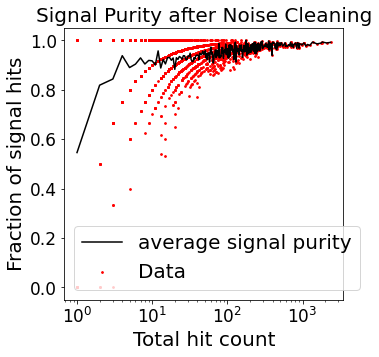

In [9]:
# Load data from .npy files
tot_hits = np.load('number_dynedge_v2_Pulses.npy')
sig_purity = np.load('physics_rate_dynedge_v2_Pulses.npy')

plt.figure(figsize=(5,5))

# Calculate the average signal purity for each unique hit count value
unique_hits = np.unique(tot_hits)
avg_purity = np.zeros_like(unique_hits, dtype=float)

for i, hit_count in enumerate(unique_hits):
    avg_purity[i] = np.mean(sig_purity[tot_hits == hit_count])

# Create the scatter plot
plt.scatter(tot_hits, sig_purity, s=3, color='red',label='Data')

# Plot the average signal purity values
plt.plot(unique_hits, avg_purity, color='black',label='average signal purity')

# Set labels and title
plt.xlabel('Total hit count',fontsize=20)
plt.ylabel('Fraction of signal hits',fontsize=20)
plt.title('Signal Purity after Noise Cleaning',fontsize=20)

# Set the x-axis scale to logarithmic
plt.xscale('log')

# Show the plot
plt.legend(loc='best',fontsize=20)
plt.show()

sorted_purity = np.sort(avg_purity)

In [10]:
#For a given PPC output file and geometry, this function returns all variables used during reconstruction.

def process_data(my_file, dom_pos):
    z_adjust = 1948.07
    om_pos_x = {f"0{dom_pos.loc[i][5]}0{dom_pos.loc[i][6]}": dom_pos.loc[i][2] for i in range(len(dom_pos))}
    om_pos_y = {f"0{dom_pos.loc[i][5]}0{dom_pos.loc[i][6]}": dom_pos.loc[i][3] for i in range(len(dom_pos))}
    om_pos_z = {f"0{dom_pos.loc[i][5]}0{dom_pos.loc[i][6]}": dom_pos.loc[i][4] + z_adjust for i in range(len(dom_pos))}

    strings = my_file.iloc[:, 1].tolist()
    doms = my_file.iloc[:, 2].tolist()
    index = [f"0{x}0{y}" for x, y in zip(strings, doms)]

    hit_pos_x = [om_pos_x[x] for x in index]
    hit_pos_y = [om_pos_y[y] for y in index]
    hit_pos_z = [om_pos_z[z] for z in index]

    v = 0.3 / 1.31  # in m/ns

    emm_loc_x = my_file.iloc[:, 12].tolist()
    emm_loc_y = my_file.iloc[:, 13].tolist()
    emm_loc_z = my_file.iloc[:, 14].tolist()

    emm_x = my_file.iloc[:, 9].tolist()
    emm_y = my_file.iloc[:, 10].tolist()
    emm_z = my_file.iloc[:, 11].tolist()

    prop_time = np.where(my_file.iloc[:, 0] == 'TR', 0.0, my_file.iloc[:, 3])
    prop_time = [float(x) for x in prop_time]

    scatt_time = [np.abs(p - np.sqrt((om_pos_x[indx] - loc_emm_x) ** 2 + (om_pos_y[indx] - loc_emm_y) ** 2 + (om_pos_z[indx] - loc_emm_z) ** 2) / v) for p, indx, loc_emm_x, loc_emm_y, loc_emm_z in zip(prop_time, index, emm_loc_x, emm_loc_y, emm_loc_z)]

    frac_scatt_time = [x / y if y != 0 else float('inf') for x, y in zip(scatt_time, prop_time)]

    true_theta = my_file.iloc[:, 7].tolist()
    true_phi = my_file.iloc[:, 8].tolist()
    true_x = [-np.sin(np.radians(theta)) * np.cos(np.radians(phi)) for theta, phi in zip(true_theta, true_phi)]
    true_y = [-np.sin(np.radians(theta)) * np.sin(np.radians(phi)) for theta, phi in zip(true_theta, true_phi)]
    true_z = [-np.cos(np.radians(theta)) for theta in true_theta]

    imp_theta = my_file.iloc[:, 5].tolist()
    imp_phi = my_file.iloc[:, 6].tolist()

    imp_z = [np.cos(x) for x in imp_theta]
    imp_x = [np.sin(x) * np.cos(y) for x, y in zip(imp_theta, imp_phi)]
    imp_y = [np.sin(x) * np.sin(y) for x, y in zip(imp_theta, imp_phi)]

    d_theta = my_file.iloc[:, 7].tolist()
    d_phi = my_file.iloc[:, 8].tolist()

    return om_pos_x, om_pos_y, om_pos_z, index, hit_pos_x, hit_pos_y, hit_pos_z, emm_loc_x, emm_loc_y, emm_loc_z, prop_time, scatt_time, frac_scatt_time, true_theta, true_phi, true_x, true_y, true_z, imp_theta, imp_phi, imp_z, imp_x, imp_y, d_theta, d_phi

## Read from PPC Output

In [18]:
my_file=pd.read_csv("Hits_hadronic_h20_v3_1GeV_20GeV_30000events_4pi", sep=' ',header=None,usecols=range(0, 15))
dom_pos=pd.read_csv("geo-f2k_h20_v3",sep='\t',header=None)

om_pos_x, om_pos_y, om_pos_z, index, hit_pos_x, hit_pos_y, hit_pos_z, emm_loc_x, emm_loc_y, emm_loc_z, prop_time, scatt_time, frac_scatt_time, true_theta, true_phi, true_x, true_y, true_z, imp_theta, imp_phi, imp_z, imp_x, imp_y, d_theta, d_phi = process_data(my_file, dom_pos)

In [34]:
# Load the saved NumPy arrays
angles_truth = np.load('angles_truth.npy')
delta_t_log_truth = np.load('delta_t_log_truth.npy')
delta_t_truth = np.load('delta_t_truth.npy')

## Construct the expected combined PDF

In [50]:
def get_optimised_bandwidth_combined(angles_truth, delta_t_log_truth, window_size_x, window_size_y):
    from scipy.stats import norm
    print("Optimising bandwidth parameter now...")
    # Define the values of 'n' to try
    n_values = [0.20,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.30]

    sample_size = 50000

    # Randomly sample from the data
   # sample_size = min(len(angles_truth), len(delta_t_log_truth))
    sample_indices = np.random.choice(np.arange(sample_size), size=sample_size, replace=False)
    sample_angles = angles_truth[sample_indices]
    sample_delta_t = delta_t_log_truth[sample_indices]

    # Calculate the histogram of the data
    histogram, x_edges, y_edges = np.histogram2d(sample_angles, sample_delta_t, bins=[50,50], density=True)

    # Calculate the bin widths
    x_bin_width = np.diff(x_edges)[0]
    y_bin_width = np.diff(y_edges)[0]

    # Calculate the CDF of the histogram
    hist_cdf = np.cumsum(histogram.flatten() * x_bin_width * y_bin_width)

    # Initialize variables to store best fit results
    best_fit_n = None
    min_ks_statistic = np.inf
    ks_values = []

    # Loop over different values of 'n'
    for n in n_values:
        # Calculate the local densities using the window sizes
        local_densities = np.zeros_like(histogram)
        for i in range(histogram.shape[0]):
            for j in range(histogram.shape[1]):
                num_neighbors = np.sum(
                    (np.abs(sample_angles - x_edges[i]) < window_size_x)
                    & (np.abs(sample_delta_t - y_edges[j]) < window_size_y)
                )
                local_densities[i, j] = num_neighbors

        # Calculate the variable bandwidths based on the local densities
        bandwidths = 1 / np.power(local_densities, n)

        # Evaluate the variable bandwidth KDE at each data point
        kde_values = np.zeros_like(histogram)
        for i in range(histogram.shape[0]):
            for j in range(histogram.shape[1]):
                weights = norm.pdf((sample_angles - x_edges[i]) / bandwidths[i, j]) * norm.pdf(
                    (sample_delta_t - y_edges[j]) / bandwidths[i, j]
                )
                kde_values[i, j] = np.sum(weights)

        bin_centers_del_t_truth = (y_edges[:-1] + y_edges[1:]) / 2
        bin_centers_angles_truth = (x_edges[:-1] + x_edges[1:]) / 2
        kde_values = kde_values / np.trapz(np.trapz(kde_values, x=bin_centers_del_t_truth, axis=1), x=bin_centers_angles_truth)

        # Calculate the CDF of the KDE values
        kde_cdf = np.cumsum(kde_values.flatten() * x_bin_width * y_bin_width)
      #  kde_cdf /= np.max(kde_cdf)

        # Calculate the KS statistic between the histogram and KDE values
        ks_statistic = np.max(np.abs(kde_cdf-hist_cdf))
        ks_values.append(ks_statistic)
        print(f"For n={n}: KS statistic = {ks_statistic}")

        # Update the best fit 'n' value if the KS statistic is lower
        if ks_statistic < min_ks_statistic:
            min_ks_statistic = ks_statistic
            best_fit_n = n

    print("Best fit n:", best_fit_n)
    # Plot the KS values versus n
    plt.plot(n_values, ks_values, marker="o", linestyle="-", color="purple")
    plt.xlabel("n", fontsize=12)
    plt.ylabel("KS statistic", fontsize=12)
    plt.title("KS Values", fontsize=15)
    plt.grid(True)

    # Show the plot
    plt.show()

    return best_fit_n

In [13]:
def get_optimised_window_combined(angles_truth, delta_t_log_truth, n_opt):
    print("Optimising window sizes now...")
    num_samples=1000

    # Specify the range of values for window sizes
    window_size_x_values = np.arange(0.1, 2.5, 0.5)
    window_size_y_values = np.arange(0.1, 6.0, 0.5)

    # Initialize the array to store the KS statistics
    ks_values = np.zeros((len(window_size_x_values), len(window_size_y_values)))

    x_range = (0, 2.5)
    y_range = (-1, 5)

    # Filter the data within the specified range
    filtered_indices = np.where(
        (angles_truth >= x_range[0])
        & (angles_truth <= x_range[1])
        & (delta_t_log_truth >= y_range[0])
        & (delta_t_log_truth<= y_range[1])
    )

    filtered_angles = angles_truth[filtered_indices]
    filtered_delta_t = delta_t_log_truth[filtered_indices]

    #Sampling a small fraction of the angles and delta_t in the high statistics region
    sampled_angles = np.random.choice(filtered_angles, size=num_samples, replace=False)
    sampled_delta_t = np.random.choice(filtered_delta_t, size=num_samples, replace=False)

    # Calculate the hist of the sampled data
    histogram, x_edges, y_edges = np.histogram2d(sampled_angles, sampled_delta_t, bins=[50,50], density=True)

    # Calculate the bin widths
    x_bin_width = np.diff(x_edges)[0]
    y_bin_width = np.diff(y_edges)[0]
    hist_cdf = np.cumsum(histogram.flatten() * x_bin_width * y_bin_width)
    #hist_cdf /= np.max(hist_cdf)

    # Optimize the window size
    for i, window_size_x in enumerate(window_size_x_values):
        for j, window_size_y in enumerate(window_size_y_values):
            # Calculate the local densities using the window sizes
            local_densities = np.zeros_like(histogram)
            for k in range(histogram.shape[0]):
                for l in range(histogram.shape[1]):
                    num_neighbors = np.sum(
                        (np.abs(sampled_angles - x_edges[k]) < window_size_x)
                        & (np.abs(sampled_delta_t - y_edges[l]) < window_size_y)
                    )
                    local_densities[k, l] = num_neighbors

            # Calculate the variable bandwidths based on the local densities
            bandwidths = 1 / np.power(local_densities, n_opt)

            # Evaluate the variable bandwidth KDE at each data point
            kde_curve_2d_truth = np.zeros_like(histogram)
            for k in range(histogram.shape[0]):
                for l in range(histogram.shape[1]):
                    weights = norm.pdf((sampled_angles - x_edges[k]) / bandwidths[k, l]) * norm.pdf(
                         (sampled_delta_t - y_edges[l]) / bandwidths[k, j]
                    )
                    kde_curve_2d_truth[i, j] = np.sum(weights)

            bin_centers_delta_t_truth = (y_edges[:-1] + y_edges[1:]) / 2
            bin_centers_angles_truth = (x_edges[:-1] + x_edges[1:]) / 2
            kde_curve_2d_truth = kde_curve_2d_truth / np.trapz(np.trapz(kde_curve_2d_truth, x=bin_centers_delta_t_truth, axis=1), x=bin_centers_angles_truth)

            # Calculate the CDF of the KDE values
            kde_cdf = np.cumsum(kde_curve_2d_truth.flatten() * x_bin_width * y_bin_width)
          #  kde_cdf /= np.max(kde_cdf)
        
        # Calculate the KS statistic between the histogram and KDE values
            ks_statistic = np.max(np.abs(kde_cdf-hist_cdf))
            ks_values[i, j] = ks_statistic

    return window_size_x_values[np.unravel_index(ks_values.argmin(), ks_values.shape)[0]], window_size_y_values[np.unravel_index(ks_values.argmin(), ks_values.shape)[1]]

In [48]:
def calculate_kde_values(angles_truth, delta_t_truth):
    #Call optimisation functions
    window_size_x = round(np.max(angles_truth) - np.min(angles_truth), 2)
    window_size_y = round(np.max(delta_t_truth) - np.min(delta_t_truth), 2)
    n_opt=get_optimised_bandwidth_combined(angles_truth,delta_t_truth, window_size_x, window_size_y)
  #  window_x_opt, window_y_opt=get_optimised_window_combined(angles_truth, delta_t_truth, n_opt)
    
    window_x_opt = round(np.max(angles_truth) - np.min(angles_truth), 2)
    window_y_opt = round(np.max(delta_t_truth) - np.min(delta_t_truth), 2)

    # Define the range of values for the KDE evaluation
    x_range = (0, 2.0)
    y_range = (-2, 25)

    # Filter the data within the specified range
    filtered_indices = np.where((angles_truth >= x_range[0])& (angles_truth <= x_range[1])& (delta_t_truth >= y_range[0])& (delta_t_truth <= y_range[1]))

    filtered_angles = angles_truth[filtered_indices]
    filtered_delta_t = delta_t_truth[filtered_indices]

    # Calculate the hist of the filtered data
    hist, x_edges, y_edges = np.histogram2d(filtered_angles, filtered_delta_t, bins=[50, 50], density=True)

    # Calculate the bin centers
    x_bin_centers = (x_edges[:-1] + x_edges[1:]) / 2
    y_bin_centers = (y_edges[:-1] + y_edges[1:]) / 2

    # Calculate the bin widths
    x_bin_width = np.diff(x_edges)[0]
    y_bin_width = np.diff(y_edges)[0]

    # Calculate the bin populations and error heights
    bin_pop = (hist / np.sum(hist)) * len(filtered_angles)
    bin_area = x_bin_width * y_bin_width
    error_heights = np.sqrt(bin_pop) / (np.sum(bin_pop) * bin_area)

    # Define the window sizes for the x and y dimensions
    window_size_x = window_x_opt
    window_size_y = window_y_opt

    # Calculate the local densities using the window sizes
    local_densities = np.zeros_like(hist)
    for i in range(hist.shape[0]):
        for j in range(hist.shape[1]):
            num_neighbors = np.sum(
                 (np.abs(filtered_angles - x_edges[i]) < window_size_x)
                & (np.abs(filtered_delta_t - y_edges[j]) < window_size_y)
            )
            local_densities[i, j] = num_neighbors
        
    n=n_opt

    # Calculate the variable bandwidths based on the local densities
    bandwidths = 1 / np.power(local_densities, n)

    # Evaluate the variable bandwidth KDE at each data point
    kde_values = np.zeros_like(hist)
    for i in range(hist.shape[0]):
        for j in range(hist.shape[1]):
            weights = norm.pdf((filtered_angles - x_bin_centers[i]) / bandwidths[i, j]) * norm.pdf(
                (filtered_delta_t - y_bin_centers[j]) / bandwidths[i, j]
            )
            kde_values[i, j] = np.sum(weights)

    kde_values = kde_values / np.trapz(np.trapz(kde_values, x=y_bin_centers, axis=1), x=x_bin_centers)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Plot the hist as a 2D map
    ax1.imshow(hist.T, origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], cmap='viridis', aspect='auto')
    ax1.set_xlim(x_range[0], x_range[1])
    ax1.set_ylim(y_range[0], y_range[1])

    # Calculate the levels for contour lines
    contour_levels = np.linspace(np.min(kde_values), np.max(kde_values), 10)

    # Plot the KDE contours on top of the hist
    ax1.contour(x_bin_centers, y_bin_centers, kde_values.T, levels=contour_levels, colors='red', linewidths=1.5)
    ax1.set_xlabel('Angle (degrees)',fontsize=15)
    ax1.set_ylabel('log($\Delta$t[ns])',fontsize=15)
    ax1.set_title('2D Variable Bandwidth KDE (n='+str(n_opt)+")",fontsize=15)

    # Calculate the data offset
    offset = np.abs(hist - kde_values) / error_heights

    # Plot the data offset as a heatmap with colorbar
    heatmap = ax2.imshow(offset.T, origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], cmap='viridis', aspect='auto')
    ax2.set_xlabel('Angle [rad]',fontsize=15)
    ax2.set_ylabel('log($\Delta$t[ns])',fontsize=15)
    ax2.set_title('Data Offset Heatmap',fontsize=15)
    plt.colorbar(heatmap, ax=ax2, label='Offset / Poisson Errors')
    ax1.set_ylim(y_range[0], y_range[1])
    ax2.set_ylim(y_range[0], y_range[1])
    ax1.set_xlim(x_range[0], x_range[1])
    ax2.set_xlim(x_range[0], x_range[1])

    ax1.grid(True)
    ax2.grid(True)

    # Adjust spacing between subplots
    plt.tight_layout()

    plt.show()


    return x_bin_centers, y_bin_centers, kde_values

Optimising bandwidth parameter now...
For n=0.2: KS statistic = 0.04409108785740029
For n=0.21: KS statistic = 0.043243367590032056
For n=0.22: KS statistic = 0.04284244699799261
For n=0.23: KS statistic = 0.04266785090219499
For n=0.24: KS statistic = 0.04263553729472508
For n=0.25: KS statistic = 0.04302580828197733
For n=0.26: KS statistic = 0.04356559288340517
For n=0.27: KS statistic = 0.04411945228713371
For n=0.28: KS statistic = 0.044615062183282705
For n=0.29: KS statistic = 0.04495302681849489
For n=0.3: KS statistic = 0.04661219308728892
Best fit n: 0.24


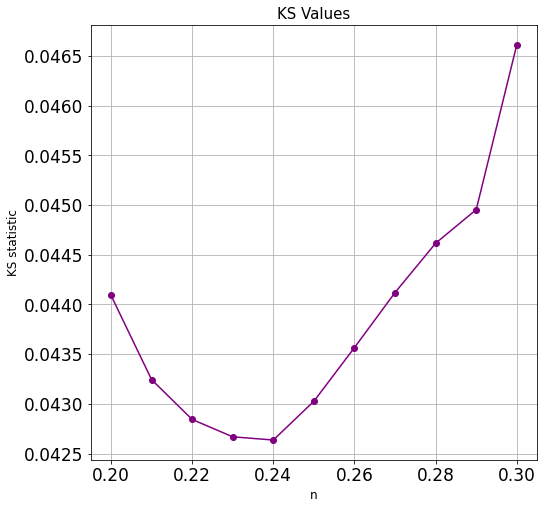

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning:

divide by zero encountered in true_divide



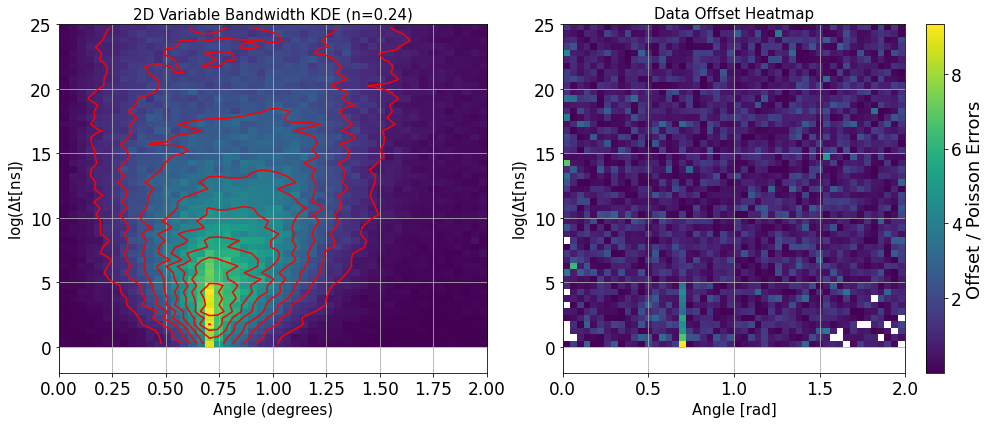

In [51]:
x_bin_centers, y_bin_centers, kde_curve_2d_truth = calculate_kde_values(angles_truth, delta_t_truth)

## Reconstruction

In [56]:
from scipy.interpolate import interp2d

v = 0.3 / 1.31  # in m/ns
hit_x = []
hit_y = []
hit_z = []
t_geo = []
t_obs = []
dom_pos = []
vert_pos = []
delta_theta = []
cutoff=0.15
hit_event = 0
indx = 0

delta_theta_combined_spread_scatt_truth = {}
std_theta_upper_combined_spread_scatt_truth = {}
std_theta_lower_combined_spread_scatt_truth = {}

delta_zen_combined_spread_scatt_truth={}
std_zen_upper_combined_spread_scatt_truth={}
std_zen_lower_combined_spread_scatt_truth={}

diff_coszen_combined_spread_scatt_truth=[]
true_coszen=[]   
reco_coszen=[]
true_azimuth=[]
reco_azimuth=[]

for i in range(len(my_file)):
    if my_file.iloc[i, 0] == 'TR':
        
        if len(hit_x)>2:
            bounds = ((-1,1), (-1,1),(-1,1))
            dir_x_guess = dir_x_truth
            dir_y_guess = dir_y_truth
            dir_z_guess = dir_z_truth

            x0 = (dir_x_guess,dir_y_guess,dir_z_guess)

            hit = np.array(list(zip(hit_x, hit_y, hit_z)))
            
            true_dir=np.array([dir_x,dir_y,dir_z])
            res = minimize(likelihood_function_combined, x0=x0, bounds=bounds, args=(t_obs, dom_pos, vert_pos, hit, x_bin_centers,y_bin_centers,kde_curve_2d_truth,))
            
            dir_x_opt,dir_y_opt,dir_z_opt = res.x
            norm_dir = np.sqrt(dir_x_opt**2 + dir_y_opt**2 + dir_z_opt**2)
            dir_x_opt /= norm_dir
            dir_y_opt /= norm_dir
            dir_z_opt /= norm_dir
            
            dir_reco_opt = np.array([dir_x_opt,dir_y_opt, dir_z_opt])
            
            rho = np.sqrt(dir_x_opt**2+dir_y_opt**2)
            az = np.arctan2(dir_y_opt,dir_x_opt)
            if az<0:
                az = az+2*np.pi
            phi_opt = az
            theta_opt = np.arctan2(rho,dir_z_opt)
            
            dir_reco_opt = np.array([np.sin(theta_opt) * np.cos(phi_opt), np.sin(theta_opt) * np.sin(phi_opt), np.cos(theta_opt)])
            delta_theta=np.rad2deg(np.arccos(np.dot(dir_reco_opt,true_dir)))
           # print(delta_theta)
              
            if str(len(hit_x)) in delta_theta_combined_spread_scatt_truth:
                delta_theta_combined_spread_scatt_truth[str(len(hit_x))].append(delta_theta)
                delta_zen_combined_spread_scatt_truth[str(len(hit_x))].append(np.abs(np.cos(theta_opt)-np.cos(theta_truth)))

            else:
                delta_theta_combined_spread_scatt_truth[str(len(hit_x))] = [delta_theta]
                delta_zen_combined_spread_scatt_truth[str(len(hit_x))]=[np.abs(np.cos(theta_opt)-np.cos(theta_truth))]
                
            diff_coszen_combined_spread_scatt_truth.append(np.cos(theta_opt)-np.cos(theta_truth))
            
            true_coszen.append(np.cos(theta_truth))    
            reco_coszen.append(np.cos(theta_opt))
            true_azimuth.append(phi_truth)
            reco_azimuth.append(phi_opt)
                        
        t_obs=[]
        dom_pos=[]
        vert_pos=[]
        dir_x=true_x[i]
        dir_y=true_y[i]
        dir_z=true_z[i]
        hit_x=[]
        hit_y=[]
        hit_z=[]
        dir_x_truth=true_x[i]
        dir_y_truth=true_y[i]
        dir_z_truth=true_z[i]
        theta_truth=np.pi-np.deg2rad(my_file.iloc[i, 7])
        phi_truth=np.deg2rad(my_file.iloc[i, 8])+np.pi  

    elif (my_file.iloc[i, 0] == 'HIT'and frac_scatt_time[i]<=cutoff):
        t_obs.append(prop_time[i])
        dom_pos.append([om_pos_x[index[i]],om_pos_y[index[i]],om_pos_z[index[i]]])
        vert_pos.append([emm_loc_x[i],emm_loc_y[i],emm_loc_z[i]])
        hit_x.append(imp_x[i])
        hit_y.append(imp_y[i])
        hit_z.append(imp_z[i])
        
# iterate through the keys of the dictionary
for key in delta_theta_combined_spread_scatt_truth:
        
    # calculate the 84th percentile
    std_theta_upper_combined_spread_scatt_truth[key] = np.percentile(delta_theta_combined_spread_scatt_truth[key], 84)
    std_zen_upper_combined_spread_scatt_truth[key] = np.percentile(delta_zen_combined_spread_scatt_truth[key], 84)

    # calculate the 16th percentile
    std_theta_lower_combined_spread_scatt_truth[key] = np.percentile(delta_theta_combined_spread_scatt_truth[key], 16)
    std_zen_lower_combined_spread_scatt_truth[key] = np.percentile(delta_zen_combined_spread_scatt_truth[key], 16)

    # calculate the mean
    mean_val_theta = np.median(delta_theta_combined_spread_scatt_truth[key])    
    delta_theta_combined_spread_scatt_truth[key] = [mean_val_theta]
    
    mean_val_zen = np.median(delta_zen_combined_spread_scatt_truth[key])
    delta_zen_combined_spread_scatt_truth[key] = [mean_val_zen]
        

## Plotting functions

In [64]:
def gen_res_hits_plot(delta_theta, std_theta_upper, std_theta_lower,color,label):

    common_keys = set(delta_theta.keys())

    x_list = []
    x_range = []
    for i in range(6, 180):
        if str(i) in common_keys and i != 88:
            x_range.append(i)
            x_list.append(str(i))

    plt.plot(x_range, [np.mean(delta_theta[key]) for key in x_list], label=label, lw=3, color=color, linestyle='--')
    err_upper = [std_theta_upper[key] for key in x_list]
    err_lower = [std_theta_lower[key] for key in x_list]
    plt.fill_between(x_range, err_lower, err_upper, alpha=0.15, color=color)

    plt.ylabel(r"|Median $\Delta\Psi$", fontsize=20)
    plt.title("Reconstruction Performance, Upgrade", fontsize=22)
    plt.grid(axis='both')
    plt.legend(loc='best', fontsize=10, frameon=True, edgecolor='black', prop={'size': 20})
    plt.xlabel("Hit Count", fontsize=20)
    plt.tick_params(axis='both', which='both', labelsize=20)
    plt.grid(True)
    plt.xlim(3, 180)

In [67]:
def gen_bias_plot(true_coszen, diff_coszen, reco_coszen, title):
    # Create a figure with a 2x2 subplot grid
    fig, axs = plt.subplots(1, 2, figsize=(18, 6))

    # Scatter Plot 1: Reconstructed - True vs True cos(zenith)
    h1 = axs[0].hist2d(true_coszen, diff_coszen, bins=100, density=True, cmap='viridis_r')
    axs[0].axhline(y=0, color='black', linestyle='solid')
    axs[0].set_xlabel('True cos(zenith)')
    axs[0].set_ylabel('Reconstructed - True cos(zenith)')
    axs[0].set_title(title)
    axs[0].grid(True)
    axs[0].set_ylim(-1, 1)
    fig.colorbar(h1[3], ax=axs[0], label='Number of events')

    # Calculate median and 68% band limits for the first subplot
    x_bins = np.arange(-1, 1.1, 0.1)
    medians = []
    sigma_1_lower = []
    sigma_1_upper = []

    for x_bin in x_bins:
        mask = (true_coszen >= x_bin - 0.05) & (true_coszen < x_bin + 0.05)
        slice_values = np.array(diff_coszen)[mask]
        median = np.median(slice_values)
        lower = np.percentile(slice_values, 16)
        upper = np.percentile(slice_values, 84)
        medians.append(median)
        sigma_1_lower.append(lower)
        sigma_1_upper.append(upper)

    # Draw median and 1 sigma contours on the first subplot
    axs[0].plot(x_bins, medians, color='red', linestyle='solid', label='Median', lw=2)
    axs[0].plot(x_bins, sigma_1_lower, color='red', linestyle='dashed', label='68% band', lw=2)
    axs[0].plot(x_bins, sigma_1_upper, color='red', linestyle='dashed', lw=2)
    axs[0].legend()

    # Scatter Plot 2: Reconstructed - True vs Reconstructed cos(zenith)
    h2 = axs[1].hist2d(reco_coszen, diff_coszen, bins=100, density=True, cmap='viridis_r')
    axs[1].axhline(y=0, color='black', linestyle='solid')
    axs[1].set_xlabel('Reconstructed cos(zenith)')
    axs[1].set_ylabel('Reconstructed - True cos(zenith)')
    axs[1].set_title(title)
    axs[1].grid(True)
    axs[1].set_ylim(-1, 1)
    fig.colorbar(h2[3], ax=axs[1], label='Number of events')

    # Calculate median and 68% band limits for the second subplot
    x_bins = np.arange(-1, 1.1, 0.1)
    medians = []
    sigma_1_lower = []
    sigma_1_upper = []

    for x_bin in x_bins:
        mask = (reco_coszen >= x_bin - 0.05) & (reco_coszen < x_bin + 0.05)
        slice_values = np.array(diff_coszen)[mask]
        median = np.median(slice_values)
        lower = np.percentile(slice_values, 16)
        upper = np.percentile(slice_values, 84)
        medians.append(median)
        sigma_1_lower.append(lower)
        sigma_1_upper.append(upper)

    # Draw median and 1 sigma contours on the second subplot
    axs[1].plot(x_bins, medians, color='red', linestyle='solid', label='Median', lw=2)
    axs[1].plot(x_bins, sigma_1_lower, color='red', linestyle='dashed', label='68% band', lw=2)
    axs[1].plot(x_bins, sigma_1_upper, color='red', linestyle='dashed', lw=2)
    axs[1].legend()

    plt.show()


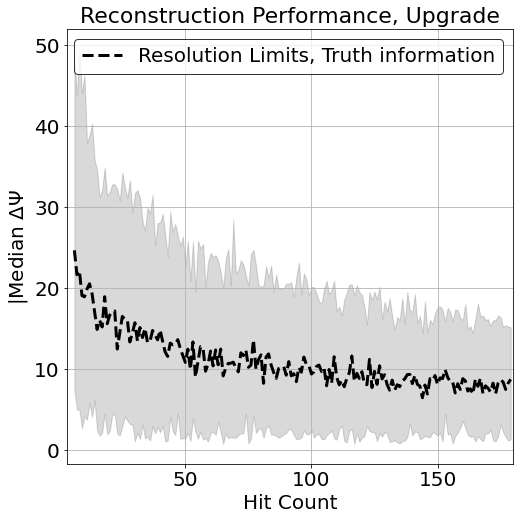

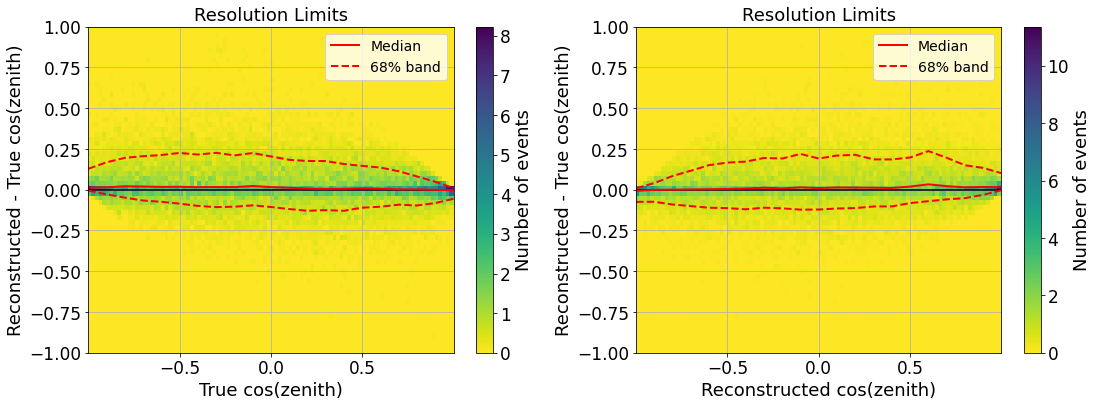

In [68]:
gen_res_hits_plot(delta_theta_combined_spread_scatt_truth, std_theta_upper_combined_spread_scatt_truth, std_theta_lower_combined_spread_scatt_truth, "black","Resolution Limits, Truth information")
gen_bias_plot(true_coszen, diff_coszen_combined_spread_scatt_truth, reco_coszen, "Resolution Limits")